The dataset in use:
https://www.kaggle.com/datasets/Cornell-University/arxiv

In order for the notebook to work, please use GPU for the preprocessing part and CPU for the training part.

# Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tqdm
!pip install --upgrade pyarrow
!python3 -m pip install --upgrade pip setuptools wheel
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [ ]:
!unzip /content/drive/MyDrive/ML_unsup/archive.zip
!mv arxiv-metadata-oai-snapshot.json data.json

In [ ]:
file_path = 'data.json'
df = pd.read_json(file_path, lines=True)

In [ ]:
print(df.head())
print(df.columns)

df.dropna(inplace=True)

In [ ]:
import pandas as pd
import cudf
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

cols_to_exclude = ['id', 'versions', 'authors_parsed']
for col in df.columns:
    if col not in cols_to_exclude:
        df[col] = df[col].astype(str).fillna('')

df['abstract'] = df['abstract'].apply(preprocess_text)

gdf = cudf.DataFrame.from_pandas(df)

In [ ]:
print(df.head())
print(df.columns)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_publication_year(row):
    if type(row['versions']) is list:
      creation_date = pd.to_datetime(row['versions'][0]['created'])
      return creation_date.year
    else:
      return np.nan

df['publication_year'] = df.apply(extract_publication_year, axis=1)
df['abstract'].fillna("", inplace=True)

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_features = tfidf_vectorizer.fit_transform(df['abstract'])
df_tfidf = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

df = pd.concat([df, df_tfidf], axis=1)

df.to_csv('preprocessed_dataset.csv', index=False)

print(df.head())
print(df.columns)

NameError: ignored

# Training and visualisation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ML_unsup/archive.zip
!mv arxiv-metadata-oai-snapshot.json data.json

Archive:  /content/drive/MyDrive/ML_unsup/archive.zip
  inflating: arxiv-metadata-oai-snapshot.json  


In [ ]:
file_path = 'data.json'
df = pd.read_json(file_path, lines=True)

          id           submitter  \
0  0704.0001      Pavel Nadolsky   
1  0704.0002        Louis Theran   
2  0704.0003         Hongjun Pan   
3  0704.0004        David Callan   
4  0704.0005  Alberto Torchinsky   

                                             authors  \
0  C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...   
1                    Ileana Streinu and Louis Theran   
2                                        Hongjun Pan   
3                                       David Callan   
4           Wael Abu-Shammala and Alberto Torchinsky   

                                               title  \
0  Calculation of prompt diphoton production cros...   
1           Sparsity-certifying Graph Decompositions   
2  The evolution of the Earth-Moon system based o...   
3  A determinant of Stirling cycle numbers counts...   
4  From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...   

                                  comments  \
0  37 pages, 15 figures; published version   
1    To appear in

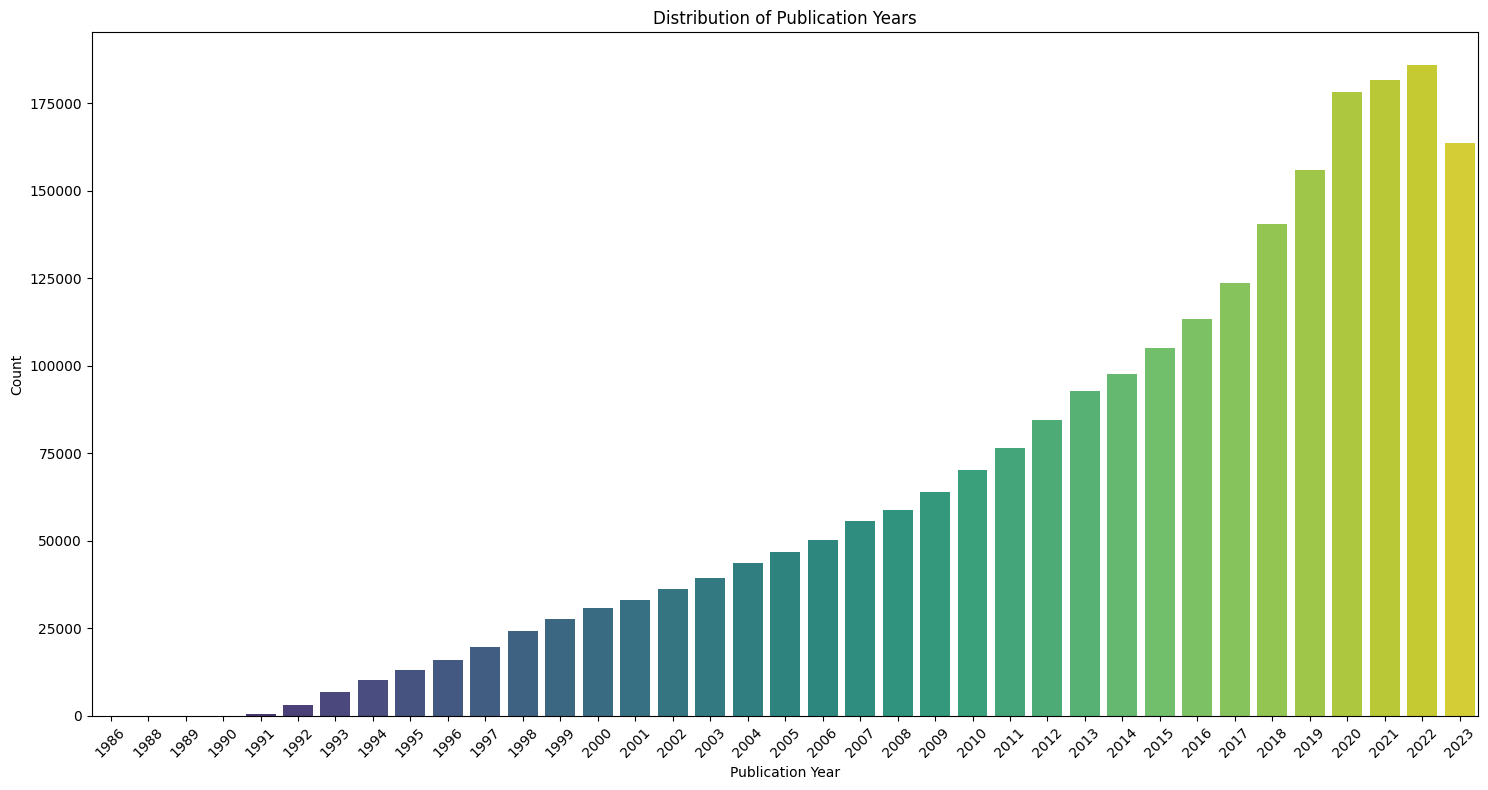

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

print(df.head())
print(df.columns)

def extract_publication_year(row):
    if type(row['versions']) is list:
      creation_date = pd.to_datetime(row['versions'][0]['created'])
      return creation_date.year
    else:
      return np.nan

df['publication_year'] = df.apply(extract_publication_year, axis=1)

plt.figure(figsize=(15, 8))
sns.countplot(data=df, x='publication_year', order=sorted(df['publication_year'].unique()), palette="viridis")
plt.title('Distribution of Publication Years')
plt.xlabel('Publication Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

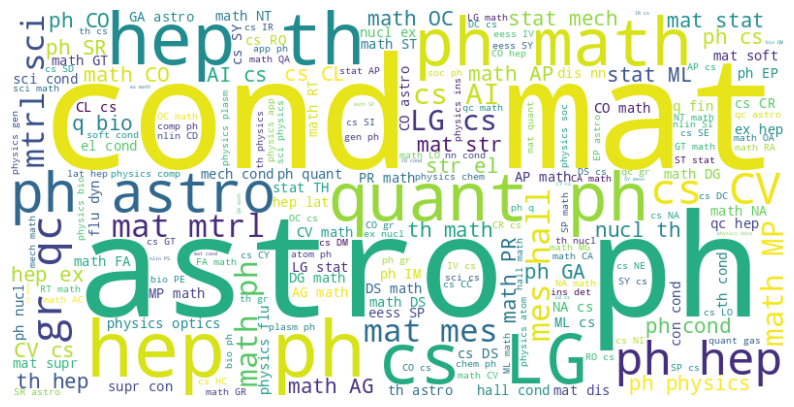

In [ ]:
from wordcloud import WordCloud

df['categories'] = df['categories'].astype(str)

wordcloud = WordCloud(width=800,
                      height=400,
                      colormap='viridis',
                      background_color='white').generate(' '.join(df['categories']))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
plt.close()

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/ML_unsup/preprocessed_dataset.csv'
df = pd.read_csv(file_path, low_memory=False)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD

df['abstract'].fillna("", inplace=True)

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_features = tfidf_vectorizer.fit_transform(df['abstract'])
df_tfidf = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X = df_tfidf

n_components = 100
svd = TruncatedSVD(n_components=n_components)
X_reduced = svd.fit_transform(X)

S = []
for k in range(2, 11):
    model = MiniBatchKMeans(n_clusters=k, random_state=0).fit(X_reduced)
    lab = model.labels_
    S.append(silhouette_score(X_reduced, lab))

optimal_k = np.argmax(S) + 2
max_score = S[optimal_k - 2]

print(f"Optimal number of clusters (k): {optimal_k}")
print(f"Maximum Silhouette Score: {max_score}")


KeyboardInterrupt: ignored

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


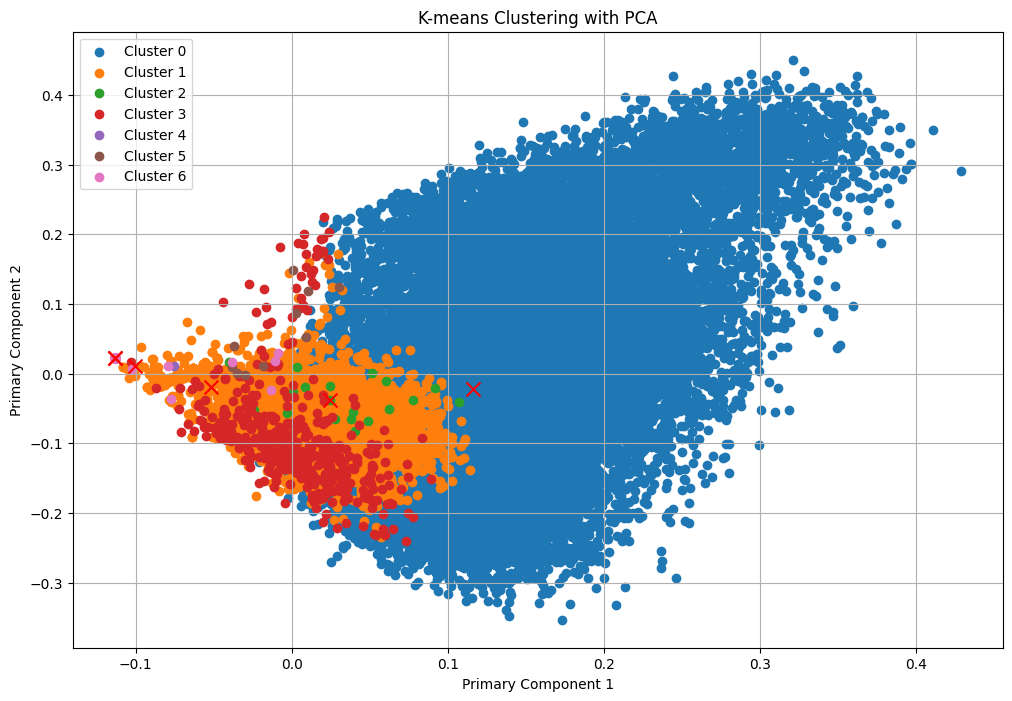

In [ ]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

optimal_k = 7
kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X)
reduced_centers = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(12, 8))

for i in range(optimal_k):
    plt.scatter(reduced_features[df['cluster'] == i][:, 0], reduced_features[df['cluster'] == i][:, 1], label=f'Cluster {i}')

plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], marker='x', s=100, color='r', zorder=10)
plt.title('K-means Clustering with PCA')
plt.xlabel('Primary Component 1')
plt.ylabel('Primary Component 2')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


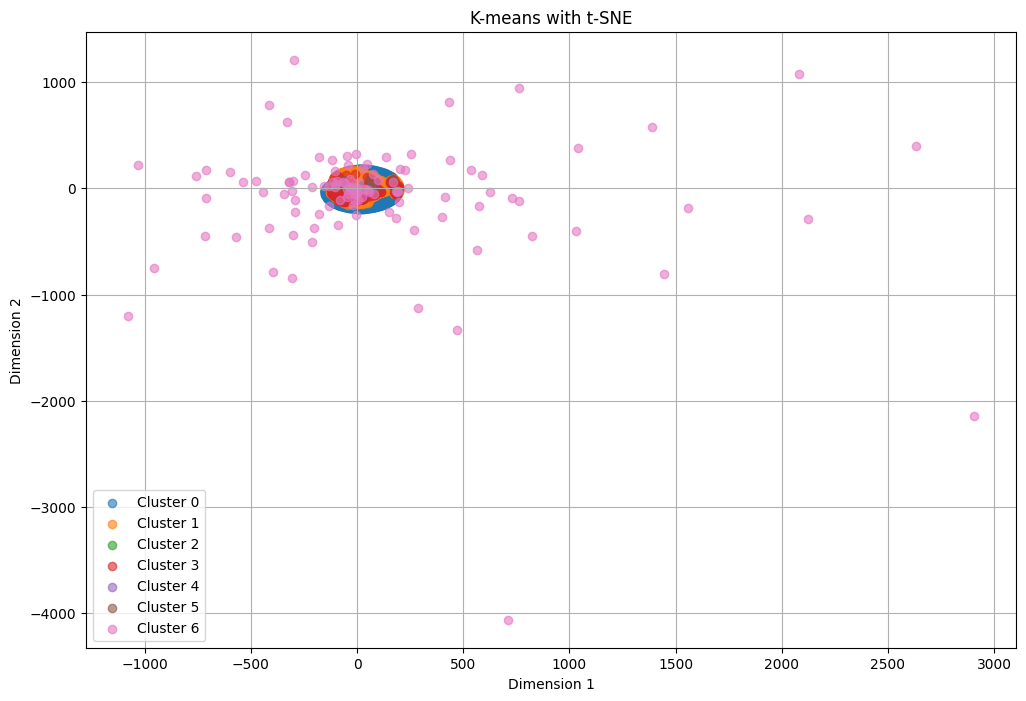

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

optimal_k = 7
kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

tsne = TSNE(n_components=2, random_state=42, perplexity=50)
reduced_features = tsne.fit_transform(X)

plt.figure(figsize=(12, 8))

for i in range(optimal_k):
    plt.scatter(reduced_features[df['cluster'] == i][:, 0],
                reduced_features[df['cluster'] == i][:, 1],
                label=f'Cluster {i}',
                alpha=0.6)

plt.title('K-means with t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


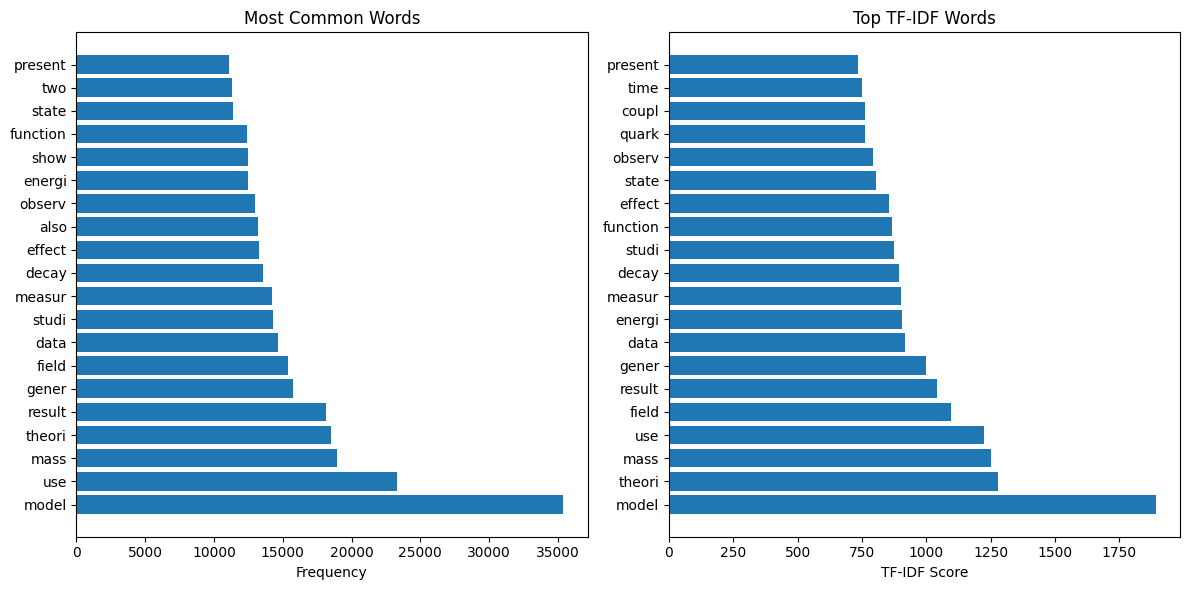

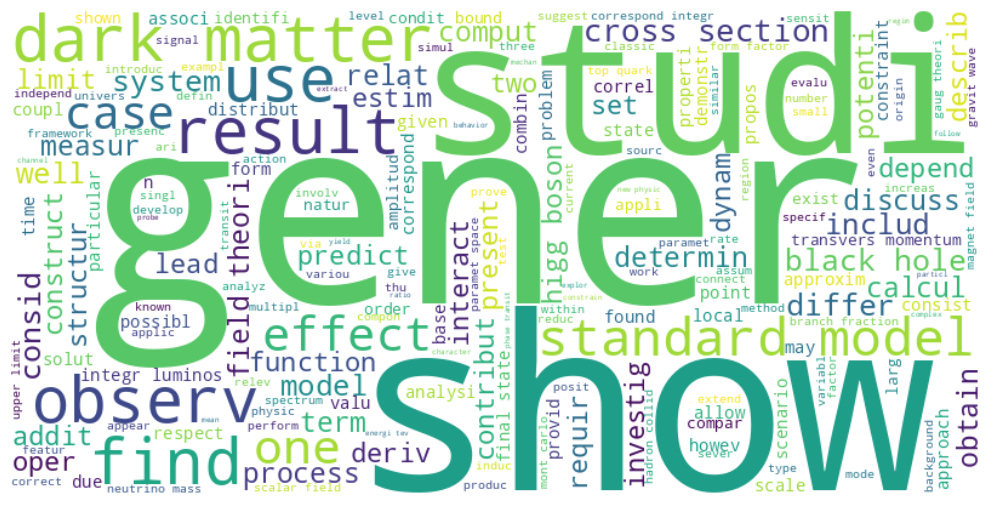

In [ ]:
import pandas as pd
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import string
import matplotlib.pyplot as plt
import nltk

nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

df['abstract'].fillna("", inplace=True)
all_abstracts = ' '.join(df['abstract'])

tokens = word_tokenize(all_abstracts)
filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stopwords.words('english')]
filtered_abstracts = ' '.join(filtered_tokens)

freq_dist = FreqDist(filtered_tokens)
most_common_words = freq_dist.most_common(20)

tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_features = tfidf_vectorizer.fit_transform(df['abstract'])
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
top_tfidf_words = tfidf_df.sum().sort_values(ascending=False).head(20)

wordcloud = WordCloud(width=800, height=400, colormap='viridis',
                      background_color='white').generate(filtered_abstracts)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh([word[0] for word in most_common_words], [word[1] for word in most_common_words])
plt.title('Most Common Words')
plt.xlabel('Frequency')

plt.subplot(1, 2, 2)
plt.barh(top_tfidf_words.index, top_tfidf_words.values)
plt.title('Top TF-IDF Words')
plt.xlabel('TF-IDF Score')

plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.tight_layout()
plt.show()